# Running on new images
This notebook will walk you step by step through the process of using a pre-trained model to detect traffic signs in an image.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chxliou/Project--CS405/blob/detection/Detection/Detection.ipynb)

# Imports

In [0]:
!pip install scipy==1.1.0

In [0]:
%tensorflow_version 1.x
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
import glob as glob
from skimage.io import imread

# Environment setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install tensorflow-object-detection-api

     |████████████████████████████████| 583kB 2.7MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 2.3MB 48.9MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-cp36-none-any.whl size=844514 sha256=7065a7a6f449651eb0e0565d032c249a00f4ada576be713e58bf8211addcec0b
  Stored in directory: /root/.cache/pip/wheels/4a/54/d0/cfca11930c4b2025d40dede77059094070a67cc3e7bd3b285f
Successfully built tensorflow-object-detection-api


In [2]:
%matplotlib inline
import sys
#sys.path.insert(0, 'path/to/your/object_detection')
# Append your Tensorflow object detection and darkflow directories to your path
sys.path.insert(0, '/content/drive/My Drive/Desktop/models/research/object_detection') # ~/tensorflow/models/research/object_detection
#sys.path.append('C:\\Users\\Alive\\Traffic-Signs-Detect-German-master\\darkflow\\darkflow-master') # ~/darkflow
print(sys.path)
from utils import label_map_util
from utils import visualization_utils as vis_util


['/content/drive/My Drive/Desktop/models/research/object_detection', '', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


# Tensorflow Object Detection API

## Model preparation 

In [0]:
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'

In [4]:
# Path to frozen detection graph. This is the actual model that is used for the traffic sign detection.
# MODEL_PATH = os.path.join('models', MODEL_NAME)
PATH_TO_CKPT = "/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/models/faster_rcnn_resnet_101/inference_graph/frozen_inference_graph.pb"

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = "/content/drive/My Drive/sustech-recognition-of-traffic-signs-master//traffic-sign-detection-master/scripts/gtsdb3_label_map.pbtxt"

NUM_CLASSES = 3
print(PATH_TO_CKPT)
print(PATH_TO_LABELS)

/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/models/faster_rcnn_resnet_101/inference_graph/frozen_inference_graph.pb
/content/drive/My Drive/sustech-recognition-of-traffic-signs-master//traffic-sign-detection-master/scripts/gtsdb3_label_map.pbtxt


## Load a (frozen) Tensorflow model into memory

In [5]:
tf.disable_v2_behavior()
import tensorflow.compat.v1 as tf
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

Instructions for updating:
non-resource variables are not supported in the long term


## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `2`, we know that this corresponds to `mandatory`.

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)


item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



## Helper code

In [0]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## Check Original test image

In [8]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images'
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.ppm'))
print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

['/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00000.ppm', '/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00001.ppm', '/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00002.ppm', '/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00003.ppm', '/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00004.ppm', '/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00005.ppm']


In [0]:
def display_Images_From_DIR(OUTPUT_IMAGE_PATHS, columns = 4,figsize=(5, 5)):
  n = len(OUTPUT_IMAGE_PATHS)
  fig=plt.figure(figsize=figsize)
  rows = int((n+columns-1)/columns)
  i=1
  for eachOutputImage in OUTPUT_IMAGE_PATHS:
    img = imread(eachOutputImage)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    i += 1
  plt.show()


In [0]:
display_Images_From_DIR(TEST_IMAGE_PATHS, 1,(50,50))

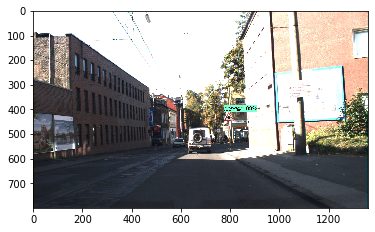

In [18]:
file ='/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00000.ppm'
img = imread(file)
plt.imshow(img)
plt.show();

## Detection

In [0]:
###

In [0]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
          # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,feed_dict={image_tensor: np.expand_dims(image, 0)})

          # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [14]:
for image_path in TEST_IMAGE_PATHS:
    image= Image.open(image_path) #注意这里的image_path是个路径，也就是说是个字符串str，下文会用到
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      image_path, #原有的代码没有这一行，但是我需要传递测试图片image的文件名给visualize_utils文件中，所以加上，对应的visualize_utils中的visualize_boxes_and_labels_on_image_array函数也要加上这个参数
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=1 #默认的框到粗细是8，但是实在太粗了
      )#the width of bounding box,default is 8
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    #save_dir = TEST_IMAGE_PATHS + '{}.jpg'.format(image_path)
    PATH_TO_TEST_IMAGES_1_DIR = '/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images' #这里可能要加上r，不然可能会有编码ucf8错误
    save_dir = os.path.join(PATH_TO_TEST_IMAGES_1_DIR, image_path)
    print(save_dir)
    vis_util.save_image_array_as_png(image_np,save_dir) #我将检测出来的图片保存在testsave_images文件夹下
     
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 775 814 409 445
/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00000.ppm

im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 387 437 501 552
im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 981 1025 388 432
/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00001.ppm
im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 894 1009 480 588
/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00002.ppm
/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test_images/00003.ppm
im_width, im_height: 1360 800
new_xmin,new_xmax,new_ymin,new_ymax: 907 950 408 459
/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/test

In [0]:
###

In [15]:
'''Note: if you wish to know the remaining hours you have for 
your colab session run the copy and run the code below.'''
import time, psutil
Start = time.time()- psutil.boot_time()
Left= 12*3600 - Start
print('Time remaining for this session is: ', Left/3600)

Time remaining for this session is:  11.689726450973087


# Result visulization

In [19]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import imread
import glob as glob
import os

Populating the interactive namespace from numpy and matplotlib


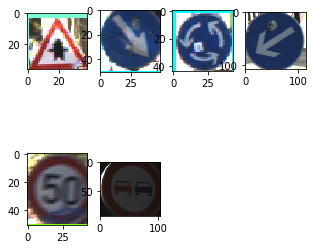

In [20]:
PATH_TO_OUTPUT_IMAGES_DIR = '/content/drive/My Drive/sustech-recognition-of-traffic-signs-master/traffic-sign-detection-master/output'
OUTPUT_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_OUTPUT_IMAGES_DIR, '*.ppm'))
display_Images_From_DIR(OUTPUT_IMAGE_PATHS)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


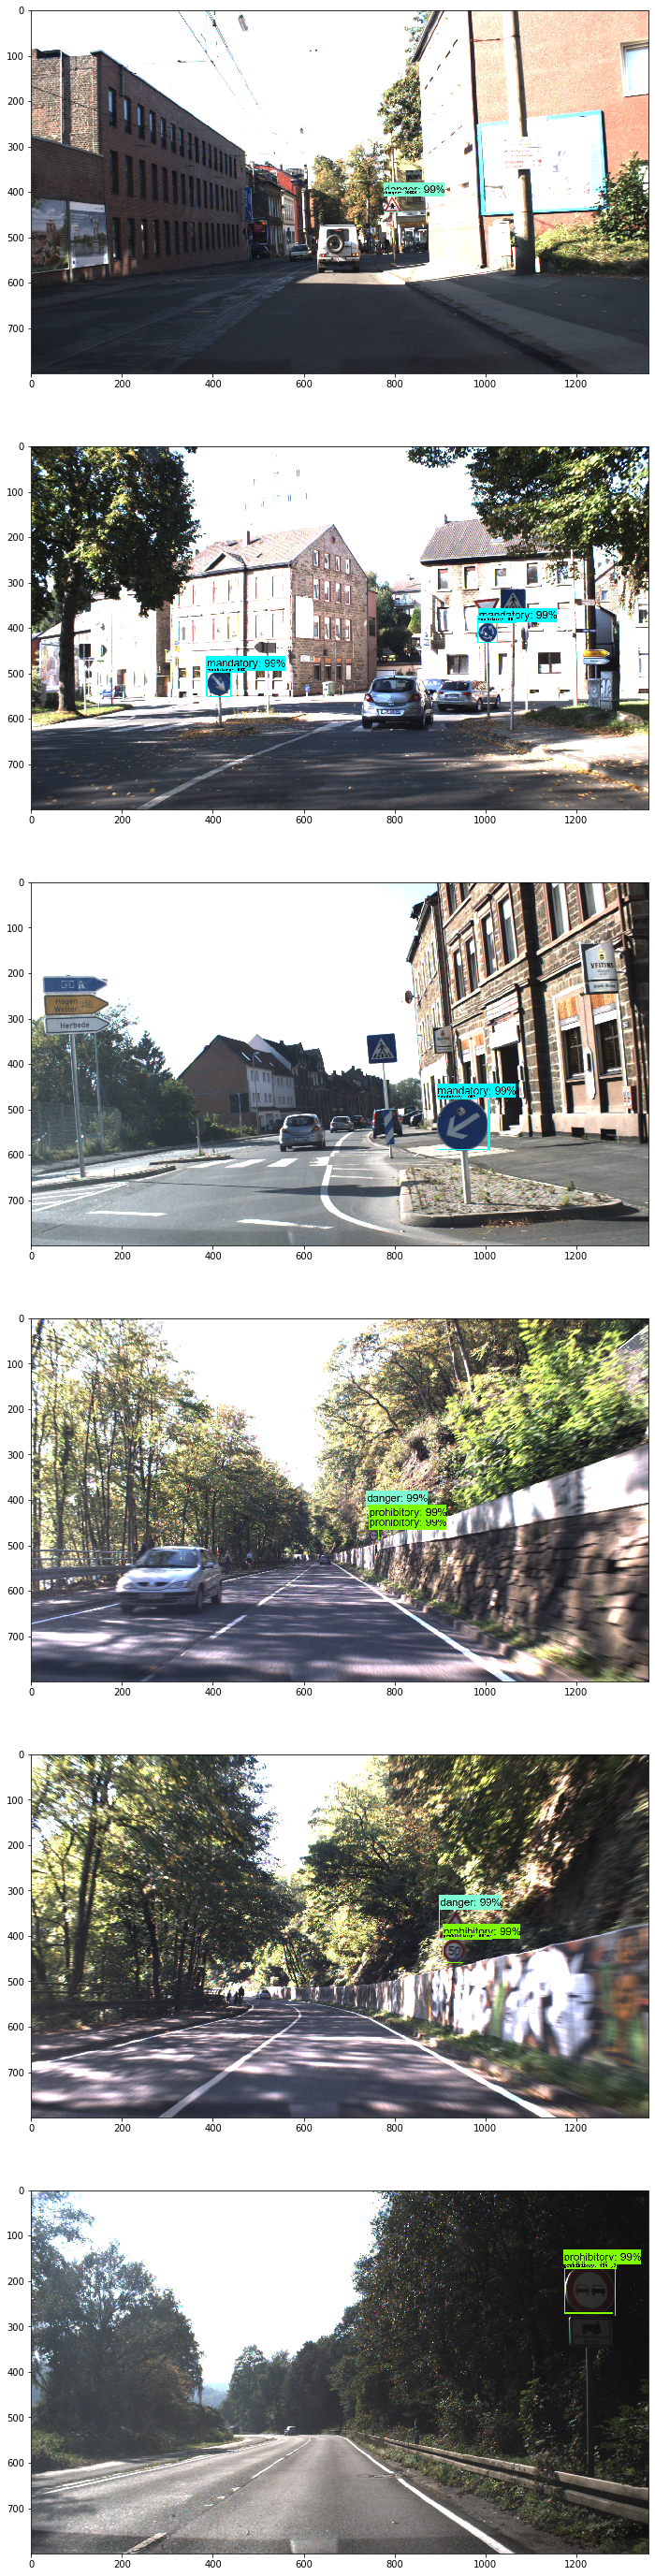

In [0]:
display_Images_From_DIR(TEST_IMAGE_PATHS, 1,(50,50))